#STEP 1 : Data acquisition and curation

In [ ]:
# install statements
# #!pip install PyPDF2


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import os
import PyPDF2
import csv
import platform

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bobch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bobch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bobch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bobch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def read_pdf(file_path):
    reader = PyPDF2.PdfReader(file_path)
    texts = []
    for page in reader.pages:
      text = page.extract_text()
      text = text.strip('')
      text = text.replace('\n', ' ')
      text = re.sub(r'\s+', ' ', text)
      texts.append(text)
    texts = ''.join(texts)
    return texts

In [ ]:
# Get current directory path
upper_dir = os.getcwd()
current_dir = upper_dir + '/src/'
print(current_dir)

# import all pdfs in folder
pdf_list = []
for file in os.listdir(current_dir):
    if file.endswith('.pdf'):
        pdf_list.append(os.path.join(current_dir, file)) # Changed to use os.path.join
print('\n'.join(pdf_list))
letter_list = []
for pdf in pdf_list:
    text = read_pdf(pdf)
    letter_list.append(text)

print(f"Number of letter extracted : {len(letter_list)}")

c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/CVBF Letter to Shareholders 2015-2017.pdf
c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/HIBB Letter to Shareholders 2015-2017.pdf
c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/HMSY Letter to Shareholders 2015-2017.pdf
c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/KELYA Letter to Shareholders 2015-2017.pdf
c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/Python - Amazone letter to shareholdesr.pdf
c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/Python - Letters to shareholders Abbott.pdf
c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/Python - Letters to Shareholders JPMorgan Chase & Co..pdf
c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project/src/Python - Walmart Letters to shareholders.pdf
Number of letter extracted : 8


In [ ]:
# wrtie the extracted letters to a csv file
filename = current_dir + '//' + 'output.csv'

# Open the file in write mode ('w') with newline='' to handle line endings correctly
with open(filename, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the data
    for letter in letter_list:
        csv_writer.writerow([letter])

print(f"Data successfully exported to {filename}")


Data successfully exported to c:\Users\bobch\OneDrive\桌面\ISEM2006 Group Project\src\\output.csv


In [ ]:
# read the csv file into a dataframe
text_csv = pd.read_csv(current_dir + '//' + 'output.csv', header=None)
data = pd.DataFrame()
data['letter'] = text_csv.astype(str).apply(lambda x: ' '.join(x), axis=1)


In [13]:
# Word tokenizer
text = data['letter'].tolist()
text = ''.join(text)
tokens = word_tokenize(text)
# Remove punctuation from each token using regex
cleaned_tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens]
cleaned_tokens = [token for token in cleaned_tokens if token]  # Remove empty tokens
cleaned_tokens
# Remove stopwords
english_stopwords = stopwords.words('english')
english_stopwords = set(english_stopwords)

tokens_filtered = []
for w in cleaned_tokens:
  if w not in english_stopwords:
    tokens_filtered.append(w)
# Lemmatization/Stemming
wl = WordNetLemmatizer()
ps = PorterStemmer()
tokens_lemmatized = [wl.lemmatize(t) for t in tokens_filtered]
tokens_stemmed = [ps.stem(t) for t in tokens_lemmatized]
tokens = tokens_stemmed

<AxesSubplot:title={'center':'Word Frequency Distribution'}, xlabel='0'>

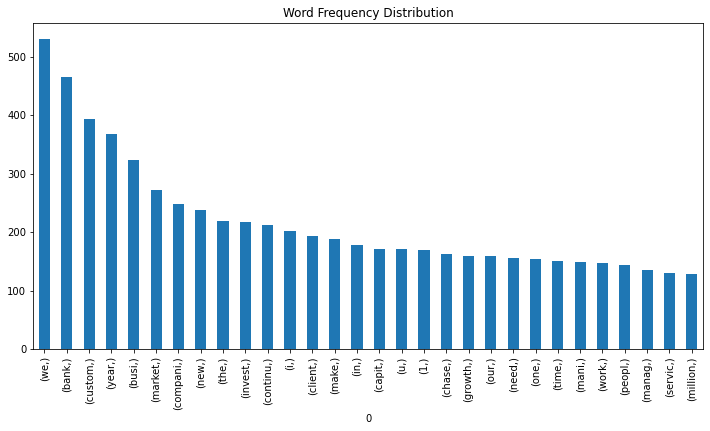

In [17]:
pd.DataFrame(tokens).value_counts()[0:30].plot(kind='bar', figsize=(12,6), title='Word Frequency Distribution')

#STEP 2 : Preprocessing and baseline analysis

## Refined Data Extraction and Restructuring


In [18]:
# The read_pdf function is already defined in a previous cell. Assuming it's in scope.
# The pdf_list and its content is also assumed to be available from previous cells.

def extract_yearly_segment(full_text, year):
    """
    Extracts the text segment relevant to a specific year from the full letter content.
    It identifies the start of the target year's section and ends before the next year's section or end of text.
    """
    target_year_str = str(year)
    # Consider years up to 2 years beyond the target year as potential delimiters for robustness
    all_years_in_scope = sorted([str(y) for y in range(2015, 2020)]) # e.g., 2015, 2016, 2017, 2018, 2019

    # Pattern to find the start of the target year's section, potentially followed by common introductory phrases
    # The intro phrases are made optional to catch cases where only the year is present.
    start_pattern = r"(?i)\b" + re.escape(target_year_str) + r"(?:\s*[:,-]?\s*(?:TO OUR SHAREHOLDERS|Dear Shareholder|DEAR FELLOW SHAREHOLDER|I am pleased to write you|Associates and Customers|Shareholders)?)?"
    start_match = re.search(start_pattern, full_text)

    if not start_match:
        return ""

    start_index = start_match.start()
    content_start_after_intro = start_index + len(start_match.group(0)) # Start search for next year after this point

    # Find the end of the target year's section by looking for the next year in chronological order
    end_index = len(full_text)
    for y_val in all_years_in_scope:
        if int(y_val) > year:
            next_year_pattern = r"\b" + re.escape(y_val) + r"(?:\s*[:,-]?\s*(?:TO OUR SHAREHOLDERS|Dear Shareholder|DEAR FELLOW SHAREHOLDER|I am pleased to write you|Associates and Customers|Shareholders)?)?"
            # Search for the next year's pattern *after* the current year's detected introduction
            next_year_match = re.search(next_year_pattern, full_text[content_start_after_intro:])
            if next_year_match:
                end_index = content_start_after_intro + next_year_match.start()
                break # Found the nearest next year, so break

    # Extract the segment and remove the initial year and introductory phrase from it
    segment = full_text[start_index:end_index].strip()
    segment = re.sub(start_pattern, '', segment, count=1, flags=re.IGNORECASE).strip()

    return segment

data_yearly_segments = []
years_to_extract = [2015, 2016, 2017]

for pdf_path in pdf_list:
    # Extract company name (re-using existing logic from previous cells)
    filename_with_ext = os.path.basename(pdf_path)
    filename_without_ext = os.path.splitext(filename_with_ext)[0]

    company_name = filename_without_ext
    match_letter = re.search(r'(.*?)(?:\sLetter[s]? to Shareholders|\sLetters to shareholders|\sletter to shareholders)(.*)', filename_without_ext, re.IGNORECASE)
    if match_letter:
        company_name = match_letter.group(1).strip()
    else:
        # Fallback for specific cases if no specific pattern is found
        if 'Amazone' in company_name:
            company_name = 'Amazon'
        elif 'Abbott Letters to shareholders Abbott' in company_name:
            company_name = 'Abbott'
        company_name = company_name.replace('Letters to shareholders', '').strip()

    full_letter_content = read_pdf(pdf_path)

    for year in years_to_extract:
        yearly_content = extract_yearly_segment(full_letter_content, year)
        data_yearly_segments.append({
            'company_name': company_name,
            'year_of_report': year,
            'full_letter_content': full_letter_content,
            'yearly_content': yearly_content
        })

df_yearly_letters = pd.DataFrame(data_yearly_segments)

print("DataFrame 'df_yearly_letters' created with yearly segments:")
print(df_yearly_letters.head())
print(f"\nTotal number of yearly segments processed: {len(df_yearly_letters)}")

# Verify sample yearly_content for 'CVBF' in '2015'
# Ensure to convert 'year_of_report' to numeric for proper filtering if it's not already
df_yearly_letters['year_of_report'] = pd.to_numeric(df_yearly_letters['year_of_report'], errors='coerce')
cvbf_2015_content = df_yearly_letters[(df_yearly_letters['company_name'] == 'CVBF') & (df_yearly_letters['year_of_report'] == 2015)]['yearly_content'].iloc[0]
print(f"\nSample 'yearly_content' for CVBF in 2015 (first 500 characters):\n{cvbf_2015_content[:500]}...")

DataFrame 'df_yearly_letters' created with yearly segments:
  company_name  year_of_report  \
0         CVBF            2015   
1         CVBF            2016   
2         CVBF            2017   
3         HIBB            2015   
4         HIBB            2016   

                                 full_letter_content  \
0  2015 TO OUR SHAREHOLDERS, CUST OMERS, AND ASSO...   
1  2015 TO OUR SHAREHOLDERS, CUST OMERS, AND ASSO...   
2  2015 TO OUR SHAREHOLDERS, CUST OMERS, AND ASSO...   
3  2015 I am pleased to write you about another s...   
4  2015 I am pleased to write you about another s...   

                                      yearly_content  
0  , CUST OMERS, AND ASSOCIA TES 7 2015 was a sol...  
1  Best Banks in America. CVB Financial Corp. ran...  
2  . This is our third bank acquired over the pas...  
3  about another successful year for Hibbett Spor...  
4  as we continue to make progress on major initi...  

Total number of yearly segments processed: 24

Sample 'yearly_conte

##Text Cleaning and Preprocessing to Yearly Segments

In [30]:
df_yearly_letters['cleaned_yearly_content'] = df_yearly_letters['yearly_content'].apply(clean_text)

# Apply preprocess_text and extract the filtered words
df_yearly_letters['filtered_words_yearly'] = df_yearly_letters['cleaned_yearly_content'].apply(lambda x: preprocess_text(x)[1])

print("Cleaned and preprocessed yearly content added to 'df_yearly_letters' DataFrame.")
print(df_yearly_letters[['company_name', 'year_of_report', 'yearly_content', 'cleaned_yearly_content', 'filtered_words_yearly']].head())

TypeError: clean_text() missing 1 required positional argument: 'column'

## Metrics Calculation

In [11]:
simple_yearly_stats = df_yearly_letters['cleaned_yearly_content'].apply(calculate_simple_stats)

stats_df_yearly = pd.json_normalize(simple_yearly_stats)
df_yearly_letters = pd.concat([df_yearly_letters, stats_df_yearly], axis=1)

# Calculate top bigrams for yearly segments
df_yearly_letters['top_bigrams_yearly'] = df_yearly_letters['filtered_words_yearly'].apply(lambda x: get_top_ngrams(x))

print("Simple baseline statistics and top bigrams calculated for yearly segments.")
print(df_yearly_letters[['company_name', 'year_of_report', 'word_count_simple', 'sentence_count_simple', 'avg_sentence_length_simple', 'unique_word_ratio_simple', 'top_bigrams_yearly']].head())

KeyError: 'cleaned_yearly_content'

## Visualization


In [12]:
# 1. Yearly Evolution of Simple Word Count per Company
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_yearly_letters, x='year_of_report', y='word_count_simple', hue='company_name', marker='o')
plt.title('Yearly Evolution of Simple Word Count per Company (Yearly Segments)')
plt.xlabel('Year of Report')
plt.ylabel('Simple Word Count')
plt.xticks(df_yearly_letters['year_of_report'].unique().astype(int)) # Ensure integer years on x-axis
plt.legend(title='Company Name')
plt.grid(True)
plt.show()

# 2. Yearly Evolution of Simple Average Sentence Length per Company
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_yearly_letters, x='year_of_report', y='avg_sentence_length_simple', hue='company_name', marker='o')
plt.title('Yearly Evolution of Simple Average Sentence Length per Company (Yearly Segments)')
plt.xlabel('Year of Report')
plt.ylabel('Simple Average Sentence Length')
plt.xticks(df_yearly_letters['year_of_report'].unique().astype(int)) # Ensure integer years on x-axis
plt.legend(title='Company Name')
plt.grid(True)
plt.show()

# 3. Aggregate data for cross-company comparison (using mean)
company_avg_yearly_stats = df_yearly_letters.groupby('company_name').agg({
    'word_count_simple': 'mean',
    'avg_sentence_length_simple': 'mean'
}).reset_index()

# 4. Comparison of Average Simple Word Count Across Companies (Yearly Segments)
plt.figure(figsize=(15, 7))
sns.barplot(data=company_avg_yearly_stats, x='company_name', y='word_count_simple', hue='company_name', palette='viridis', legend=False)
plt.title('Comparison of Average Simple Word Count Across Companies (Yearly Segments)')
plt.xlabel('Company Name')
plt.ylabel('Average Simple Word Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Comparison of Average Simple Sentence Length Across Companies (Yearly Segments)
plt.figure(figsize=(15, 7))
sns.barplot(data=company_avg_yearly_stats, x='company_name', y='avg_sentence_length_simple', hue='company_name', palette='magma', legend=False)
plt.title('Comparison of Average Simple Sentence Length Across Companies (Yearly Segments)')
plt.xlabel('Company Name')
plt.ylabel('Average Simple Sentence Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Visualizations for yearly trends and cross-company comparisons generated for yearly segments.")

ValueError: Could not interpret value `word_count_simple` for parameter `y`

<Figure size 1080x504 with 0 Axes>